In [1]:
import requests

## Suche

Der einfachste Weg, den gewünschten API-Aufruf zu konstruieren, führt über die Web-Oberfläche. Hier können die zunächst Suchparameter eingestellt werden, dann per Rechtsklick mit gedrückter Strg-Taste das Kontextmenü aufrufen und unter *Export* das gewünschte Format wählen. Ein Klick öffnet das Suchergebnis im gewünschten Format.

Die Webfrontend-Ansicht, die unter der URL <https://berlin.museum-digital.de/objects?s=place:10651> aufrufbar ist, entspricht <https://berlin.museum-digital.de/json/objects?&s=place%3A10651>.

In [108]:
requests.get("https://berlin.museum-digital.de/json/objects?s=place:10651").json()

[{'objekt_id': 140903,
  'objekt_name': 'Ansichtskarte "Wassersturz im Victoria-Park" und Belle-Alliance Platz, koloriert',
  'objekt_inventarnr': '2024/123_4753',
  'objekt_erfasst_am': '2024-10-24 17:53:05',
  'institution_id': 1,
  'institution_name': 'FHXB Friedrichshain-Kreuzberg Museum',
  'image': 'data/berlin/images/1/140903-2024123_4753/ansichtskarte_wassersturz/200w_ansichtskarte-wassersturz-im-victoria-park-und-belle-alliance-platz-koloriert-140903-280795-3.jpg',
  'image_height': 130,
  'total': 288},
 {'objekt_id': 139354,
  'objekt_name': 'Werbepostkarte Buchhandlung „Gebrüder Ulbrich“, Königgrätzer Straße 71, Stresemannstraße',
  'objekt_inventarnr': '2024/123_4407',
  'objekt_erfasst_am': '2024-10-24 18:13:55',
  'institution_id': 1,
  'institution_name': 'FHXB Friedrichshain-Kreuzberg Museum',
  'image': 'data/berlin/images/1/139354-2024123_4407/werbepostkarte_buchhandlu/200w_werbepostkarte-buchhandlung-gebrueder-ulbrich-koeniggraetzer-straSse-71-stresemannstraSse-8374

## Mehr als 24 Objekte auf einen Streich

Standardmäßig gibt das Webinterface und die API 24 Objekte je Aufruf aus. Dieser Wert kann auf max. 100 erhöht werden und mit dem Parameter `gbreitenat` übergeben werden. Über die Treffer kann mit dem Parameter `startwert` iteriert werden, indem `startwert` bei jedem Aufruf um `gbreitenat` erhöht wird. Um sich also eine größere Menge (sprich i.d.R. mehr als 100) an Objekten ausgeben zu lassen, bietet sich folgendes Vorgehen an: https://nat.museum-digital.de/objects?instnr=22&section=results_list&mode=grid&gbreitenat=100

In [91]:
apiURL = "https://nat.museum-digital.de/json/objects?&s=gabel"

In [100]:
objektIDs = list()

rows = 100
offset = 0
while True:   
    res = requests.get(apiURL + f"&startwert={offset}&gbreitenat={rows}")
    offset += rows
    if 'status' in res.json() and res.json()['status'] == 'Error':
        break
    else:
        for _ in res.json():
            objektIDs.append(_['objekt_id'])

Mithilfe der gesammelten IDs kann nun ein Gesamtabzug der Daten erstellt werden.

In [106]:
from tqdm import tqdm # Zeigt den Forschritt an
dump = []
for ID in tqdm(objektIDs):
    obj = requests.get(f"https://nat.museum-digital.de/json/object/{ID}").json()
    dump.append(obj)

In [118]:
herstellungsdaten = []
for obj in dump:
    for event in obj['object_events']:
        if event['event_type'] == 1:
            if 'time' in event:
                time_end =  event['time']['time_end']
                try:
                    herstellungsdaten.append(int(time_end))
                except Exception as e:
                    pass

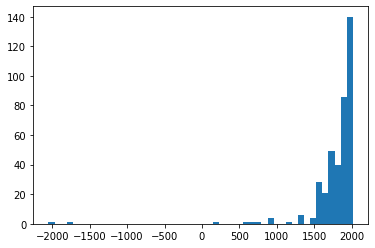

In [121]:
from matplotlib import pyplot as plt

plt.hist(herstellungsdaten, bins = 50)
plt.show()

## Liste der Institutionen

In [10]:
res = requests.get("https://nat.museum-digital.de/institutions?output=json")

In [29]:
# Die Institutionen mit den 5 größten Online-Beständen

# nach größe Sortieren
instSortiert = sorted([_ for _ in res.json()], key = lambda x:x['institution_objects'], reverse = True)

for _ in instSortiert[:6]:
    print(f"{_['institution_id']}, {_['institution_name']} ({_['institution_objects']} Objekte)")

583, Ethnologisches Museum (76993 Objekte)
820, Herzog Anton Ulrich-Museum (72615 Objekte)
589, Münzkabinett (48683 Objekte)
588, Museum für Vor- und Frühgeschichte (24933 Objekte)
587, Kupferstichkabinett (22293 Objekte)
585, Kunstbibliothek (20356 Objekte)


### Sammlungen

In [41]:
res = requests.get("https://global.museum-digital.org/json/collections")

In [42]:
collections = []
for inst in res.json():
    for coll in inst['collection']:
        collections.append(coll['collection_id'])
        if coll['collection_no_of_subcollections'] > 0:
            for subcoll in coll['collection_subcollections']:
                collections.append(subcoll['subcollection_id'])

In [40]:
len(collections)

9389